In [1]:
# Рисовать графики сразу же
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

from google.colab import files
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [130]:
%load_ext tensorboard

In [133]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [29]:
files.upload()
!ls


Saving airline-passengers.csv to airline-passengers (1).csv
'airline-passengers (1).csv'   PJME_Потребление_энергии_D.csv
 airline-passengers.csv        sample_data


Прочитаем данные о пасажиропотоке для авиалиний из файла

In [31]:
df = pd.read_csv('airline-passengers.csv')
#df = pd.read_csv('PJME_Потребление_энергии_D.csv')
df.index = df.Month
df.drop(['Month'],axis=1,inplace=True)

In [32]:
df.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [34]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


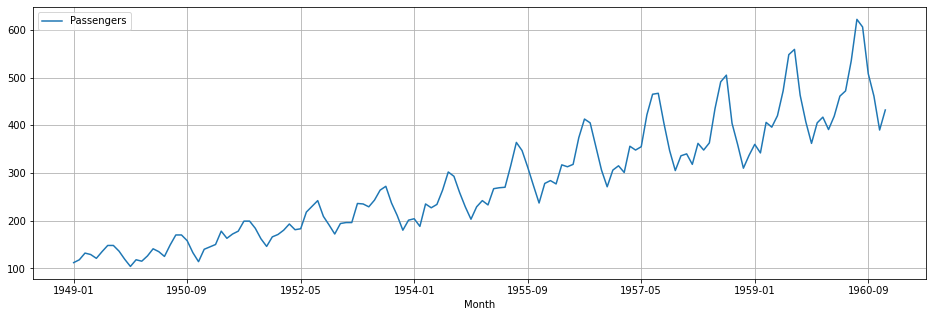

In [36]:
df.plot (figsize = (16,5))
plt.grid('On')
plt.show()

In [37]:
data = df.copy()

Делаем нормализацию


In [38]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

Делим данные

In [332]:
train_split = 70
data_v =  normalize(data.values, train_split)
data_f = pd.DataFrame(data_v)

Создаем данные для обучения

In [333]:
# список признаков, по которым будем учить
channelIndexes = [0]

# длина теста
valLen = 100
# длина истории для работы
xLen = 3
# отступ тестов от тренировок
bias = 2

# делим
train_data = data_f.iloc[0 : train_split - 1,channelIndexes]
val_data = data_f.iloc[train_split+bias:,channelIndexes]

In [334]:
train_data.head()

,0
0,-1.467932
1,-1.342032
2,-1.048266
3,-1.111216
4,-1.279082


Формируем параметры для генерации выборки

In [335]:
# шаг по данным для построения обучающих примеров
step = 1

# длина прошлого 
past = xLen
p = past
# горизонт предсказания
future = 1
h=future

# параметры модели для обучения
learning_rate = 0.001
batch_size = 144
epochs = 10

Выделяем части на обучение и проверку

In [336]:
Chanel_numb = len(channelIndexes)

start = xLen + future
end = start + train_split -1

xTrain = train_data[[train_data.columns[i] for i in range(Chanel_numb)]].values
yTrain = data_f.iloc[start:end,0].values

sequence_length = int(xLen / step)


x_end = len(val_data) - xLen - future

label_start = len(train_data)+bias+xLen + future + 1

xVal = val_data.iloc[:x_end][[val_data.columns[i] for i in range(Chanel_numb)]].values
yVal = data_f.iloc[label_start:,0].values

In [337]:
print(xTrain.shape)

print(yTrain.shape)


print(xVal.shape)

print(yVal.shape)

(69, 1)
(69,)
(68, 1)
(68,)


Посмотрим на разбитые данные

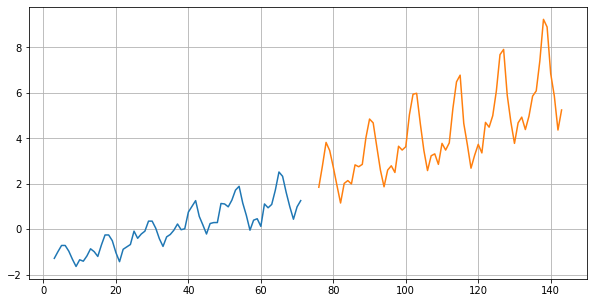

In [338]:
plt.figure(figsize=(10,5))
plt.plot(data_f.index[xLen:yTrain.shape[0]+xLen],yTrain[:])
plt.plot(data_f.index[yTrain.shape[0]+xLen+bias+future+1:],yVal[:])
plt.grid('on')
plt.show()

Используем механизм формирования пакетов для обучения

In [340]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)

In [341]:
for batch in dataset_train.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (67, 3, 1)
Target shape: (67,)


In [342]:
inputs[2,:,0]

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([-1.04826587, -1.11121577, -1.2790822 ])>

In [343]:
targets[0]

<tf.Tensor: shape=(), dtype=float64, numpy=-1.2790821979587248>

In [344]:
for batch in dataset_val.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (66, 3, 1)
Target shape: (66,)


In [345]:
inputs[2,:,0]

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([1.78448004, 1.82644664, 1.84742995])>

In [346]:
targets[0]

<tf.Tensor: shape=(), dtype=float64, numpy=1.8474299475086997>

In [197]:
import os
import datetime
logdir = os.path.join("logs2", datetime.datetime.now().strftime("%Y%m%d - %H%M$S"))
tensorboard_callback = TensorBoard( logdir, histogram_freq = 1)

### **сеть: LSTM слои+Conv1D +Dense слой.**

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.9431 - mae: 0.7881 - val_loss: 19.3974 - val_mae: 4.0516
Epoch 2/100
1/1 [==============================] - 0s 143ms/step - loss: 0.8861 - mae: 0.7597 - val_loss: 17.8708 - val_mae: 3.8695
Epoch 3/100
1/1 [==============================] - 0s 150ms/step - loss: 0.8324 - mae: 0.7312 - val_loss: 16.4056 - val_mae: 3.6857
Epoch 4/100
1/1 [==============================] - 0s 484ms/step - loss: 0.7819 - mae: 0.7036 - val_loss: 14.9989 - val_mae: 3.4995
Epoch 5/100
1/1 [==============================] - 0s 130ms/step - loss: 0.7346 - mae: 0.6780 - val_loss: 13.6507 - val_mae: 3.3107
Epoch 6/100
1/1 [==============================] - 0s 140ms/step - loss: 0.6904 - mae: 0.6558 - val_loss: 12.3642 - val_mae: 3.1190
Epoch 7/100
1/1 [==============================] - 0s 137ms/step - loss: 0.6494 - mae: 0.6375 - val_loss: 11.1463 - val_mae: 2.9275
Epoch 8/100
1/1 [==============================] - 0s 133ms/step - loss: 0.6119

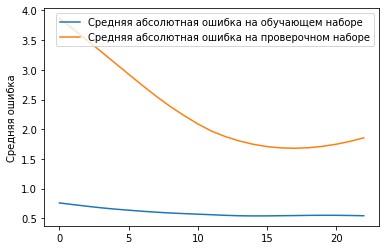

In [347]:
callback = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(244, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
#model.add(LSTM(64, return_sequences="True"))
#model.add(Conv1D(64, 3, activation="linear"))
#model.add(Conv1D(64, 1, activation="linear"))
model.add(Flatten())
model.add(Dense(3, activation="linear"))
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=100,
    validation_data=dataset_val,
    callbacks=[callback])


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
#%tensorboard --logdir logs

In [348]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

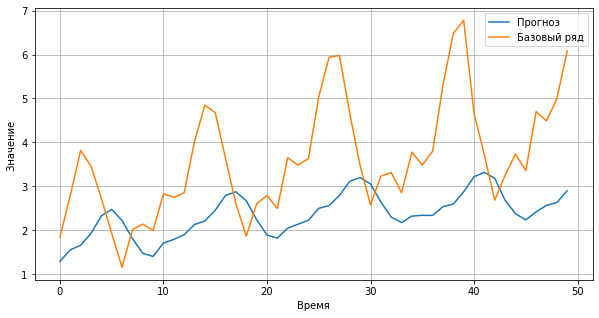

In [349]:
start = 0
step = 50
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[h+start:h+start+step], 
         label='Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

###**Удалось поймать цикл**. 
### Модель улучшилась за счет увеличения **размера пакета**, и количества units в LSTM**. Чем больше units, тем отчетливее виден цикл.**### 

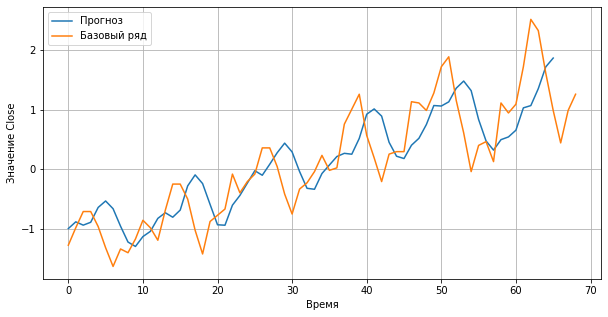

In [350]:
start = 0


plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred[h+start:h+train_split], 
         label='Прогноз')
plt.plot(yTrain.flatten()[start:train_split], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

In [351]:
def correlate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()
  
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

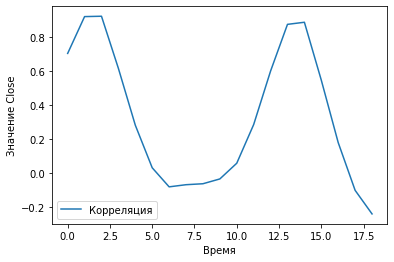

In [352]:
corr = []
start = 0
step = 50
yLen = yVal.shape[0]
yValF = yVal[start:start+step].flatten()
yPredVal = predVal[h+start:start+step+h]
for i in range(1,20):
  corr.append(correlate(yValF[:-i], yPredVal[i:]))
  
plt.plot(corr, 
         label='Корреляция')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

In [353]:
corr


[0.7034621321746359,
 0.9204650120327987,
 0.9225472575802195,
 0.6151697705310168,
 0.28039683489139355,
 0.02936827016430241,
 -0.08304330419148413,
 -0.07044705624401257,
 -0.06475065115647369,
 -0.03642146016198945,
 0.05616843714245286,
 0.2840296313025621,
 0.5995410136309,
 0.8747446979846665,
 0.8870951898122073,
 0.5456051270495177,
 0.1776801565978441,
 -0.10357899533278817,
 -0.24260170523961658]